### VQE Demo
---

by following [this tutorial](https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb).

In [4]:
import numpy as np
from random import random
from scipy import array
from scipy.optimize import minimize

from qiskit import *
from qiskit.extensions.standard import *
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import ExactEigensolver

In [5]:
# a simple 1 qubit Hamiltonian

def H1(a, b, c, d):
    """
    this hamiltonian operator represents:
    H = a*I + b*Z + c*X + d*Y
    """
    pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": a}, "label": "I"},
                   {"coeff": {"imag": 0.0, "real": b}, "label": "Z"},
                   {"coeff": {"imag": 0.0, "real": c}, "label": "X"},
                   {"coeff": {"imag": 0.0, "real": d}, "label": "Y"}
                  ]
    }
    return WeightedPauliOperator.from_dict(pauli_dict)


def pauli_operator_to_dict(pauli_operator):
    """
    from WeightedPauliOperator return a dict:
    {I: 0.7, X: 0.6, Z: 0.1, Y: 0.5}.
    :param palui_operator: qiskit's WeightedPauliOperator
    :return: a dict in the desired form.
    """
    d = pauli_operator.to_dict()
    paulis = d['paulis']
    paulis_dict = {}

    for x in paulis:
        label = x['label']
        coeff = x['coeff']['real']
        paulis_dict[label] = coeff

    return paulis_dict


In [6]:
h1 = H1(1,1,1,1)
print(h1.print_details())

I	(1+0j)
Z	(1+0j)
X	(1+0j)
Y	(1+0j)



In [7]:
a, b, c, d = (random(), random(), random(), random())
h1 = H1(a, b, c, d)
print(h1.print_details())

I	(0.2904242376361772+0j)
Z	(0.34923211911419794+0j)
X	(0.36416311693057035+0j)
Y	(0.587859906645438+0j)



In [8]:
print(pauli_operator_to_dict(h1))

{'I': 0.2904242376361772, 'Z': 0.34923211911419794, 'X': 0.36416311693057035, 'Y': 0.587859906645438}


In [9]:
ee = ExactEigensolver(h1, k=2)
result = ee.run()
print("the ground state energy: {:.5f}".format(result["energy"]))

the ground state energy: -0.48427


In [10]:
def quantum_state_preparation(circuit, params):
    q = circuit.qregs[0]
    circuit.rx(params[0], q[0])
    circuit.ry(params[1], q[0])
    return circuit

In [11]:
H_gate = U2Gate(0, np.pi).to_matrix()
Y_gate = U2Gate(0, np.pi/2).to_matrix()

In [12]:
def vqe_circuit(params, measure):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circuit = QuantumCircuit(q, c)
    circuit = quantum_state_preparation(circuit, params)
    
    if measure == 'Z':
        circuit.measure(q[0], c[0])
    elif measure == 'X':
        circuit.u2(0, np.pi, q[0])
        circuit.measure(q[0], c[0])
    elif measure == 'Y':
        circuit.u2(0, np.pi/2, q[0])
        circuit.measure(q[0], c[0])
    else:
        raise ValueError("Should not be here")
    return circuit

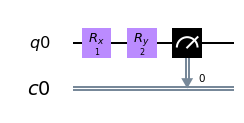

In [13]:
circuit = vqe_circuit([1,2],"Z")
circuit.draw(output='mpl')

In [108]:
def get_or_else_zero(d, key):
    if key in d:
        return d[key]
    return 0

def quantum_module(params, measure):
    if measure == 'I':
        return 1
    elif measure == 'Z':
        circuit = vqe_circuit(params, 'Z')
    elif measure == 'X':
        circuit = vqe_circuit(params, 'X')
    elif measure == 'Y':
        circuit = vqe_circuit(params, 'Y')
    else:
        raise ValueError("Should not be here")
    
    shots = 1000
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    expected_value = (get_or_else_zero(counts, '0') - get_or_else_zero(counts, '1')) / shots  # why is expected value calculated this way??
#     print(get_or_else_zero(counts, '0'), get_or_else_zero(counts, '1'), expected_value)
    return expected_value

In [109]:
pauli_dict = pauli_operator_to_dict(h1)

def vqe(params):
    quantum_module_I = get_or_else_zero(pauli_dict, 'I') * quantum_module(params, 'I')
    quantum_module_Z = get_or_else_zero(pauli_dict, 'Z') * quantum_module(params, 'Z')
    quantum_module_X = get_or_else_zero(pauli_dict, 'X') * quantum_module(params, 'X')
    quantum_module_Y = get_or_else_zero(pauli_dict, 'Y') * quantum_module(params, 'Y')
    
    classical_adder = quantum_module_I + quantum_module_Z + quantum_module_X + quantum_module_Y
    return classical_adder
    

In [110]:
params = array([np.pi, np.pi])
tol = 1e-6

%time vqe_result = minimize(vqe, params, method="Powell", tol=tol)

/Users/George/anaconda/envs/quantum/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  """Entry point for launching an IPython kernel.


CPU times: user 6 s, sys: 90.1 ms, total: 6.09 s
Wall time: 6.22 s


In [111]:
print(vqe_result.fun, result["energy"])

0.15429724872341835 0.16042085440550677
